In [20]:
import subprocess
import os
import shutil
import warnings

warnings.filterwarnings("ignore")
from ast import literal_eval
import itertools
import matplotlib.pyplot as plt
import toolsets.spectra_operations as so
import seaborn as sns
from tqdm import tqdm
from operator import itemgetter
import time
import numpy as np
import sys
sys.path.append('yuanyue_code')

import re
import pandas as pd

# import spectral_entropy as se

import toolsets.denoising_related_functions as de
import pandas as pd
import toolsets.ms2_spectra_plotter as ms2plotter
%load_ext autoreload
%autoreload 2
import toolsets.mass_to_formula as mtf
import toolsets.precursor_matching as pm
import toolsets.mass_recalibration as mr
# import requests
# import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
# this is reading in the ms dial alignment result
data_height = pm.readin_MSDIAL("demo_data/Height_2_2021619144.txt")
# this is reading in the standard list, please use exact same column name
# if you do not have the precorsormz monoisotopic mass precalculated, the toolset has functions that can help you
# please refer adduct_calculator.py
# the mix_label column is very important, please make sure it has the same name as in the alignment result
sample_list_cor = pd.read_csv("demo_data/standard_list.csv")
# this is defining the mass error of picking the precursormz
mass_error =  0.01
# the parameters are: alignment result, sample list, mass error, allowed adducts to be searched, comments, if using ppm as mass error
# default mass error is in Da, but ppm is also allowed
data = pm.precursor_matching(data_height, sample_list_cor, mass_error, ['[M+H]+', '[M+NH4]+','[M+Na]+'], "EAD_HILIC", ppm = False)

100%|██████████| 73/73 [00:06<00:00, 10.72it/s]


In [26]:
# performing mass recalibration, if everything works out in previous step, this will work without issue
# the recalibrated msms is stored in new column, msms_recalibrated
data_r = mr.data_recalibrate(data, save_diff=True)

In [17]:
# this chunk of code is for seeing the difference of ms1 before and after the recalibration
# it is not necessary, if you want ot use it, the data_recalibrate must have the save_diff parameter set to be true

# fig, ax = plt.subplots(
#     figsize = (7, 5)
#                       )
# ax= sns.histplot(data=data_hilic_r, x="diff_raw", multiple="stack", kde = True, color = "red")
# ax = sns.histplot(data=data_hilic_r, x="diff_recalibrated", multiple="stack", kde = True,color = "green")
# # ax.set_title("Peak number difference after denoising", fontsize = 16)
# ax.set_xlabel("Mass difference of precursor ion (Da)", fontsize = 18)
# ax.set_ylabel("Number of Peaks", fontsize = 18)
# ax.grid(False)
# plt.legend(labels=["Before recalibration","After recalibration"], loc = 'upper right',fontsize=16)
# plt.savefig('data_demo/recalibration.tiff', dpi = 300,facecolor = 'white', edgecolor = 'white')

In [35]:
# this method creates consensus spectra
# default method is 'weighedaverage'
# another allowed method is 'consensus', which is the method described in 'Quality Control for Building Libraries from Electrospray Ionization Tandem Mass Spectra'
# the consensus spectra will be stored and replace the original 'msms' column
data_r = so.duplicate_handling(data_r, typeofmsms='msms_recalibrated')

100%|██████████| 3/3 [00:11<00:00,  3.89s/it]


In [37]:
# denoising spectra
data_r = so.denoising(data_r,'msms', mass_error = 0.01, ifppm = False)


100%|██████████| 3/3 [00:00<00:00,  3.47it/s]


In [56]:
# evaluating denoising result
# if total explained intensity is less than 80%, it will be flagged
# if there is a single peak unassigned with relative intensity larger than 20%, it will also be flagged
# msms1 is and msms2 are the the raw msms and denoised msms, respectively
data_r=so.denoising_evaluation(data_r,msms1 = 'msms', msms2 = 'msms_denoised', min_explained_intensity = 80, allowed_max_unassigned_intensity = 30)

,NAME,key,PRECURSORMZ,InChIKey,Formula,ExactMass,Adduct,Spectrum_type,RETENTIONTIME,Average_mz,...,intensity,mix_label,Ion_mode,msms_recalibrated,diff_raw,diff_recalibrated,msms_denoised,explained_intensity,max_unassigned_intensity,evaluations
88,N-Acetyl-epsilon-caprolactam,QISSLHPKTCLLDL-UHFFFAOYSA-N[M+H]+,156.10191,QISSLHPKTCLLDL-UHFFFAOYSA-N,C8H13NO2,155.09463,[M+H]+,MS2,0.21,156.09988,...,7933,Inventory 2,P,50.016055\t44.0\n51.024245\t160.0\n53.040105\t...,-0.002030,0.000899,50.016055\t3.832753\n51.024245\t13.937282\n53....,0.941138,6.445993,good quality
89,Carbamazepine,FFGPTBGBLSHEPO-UHFFFAOYSA-N[M+Na]+,259.084184,FFGPTBGBLSHEPO-UHFFFAOYSA-N,C15H12N2O,236.09496,[M+Na]+,MS2,0.251,259.09387,...,14867,Inventory 2,P,50.016055\t96.0\n51.024945\t228.0\n52.026235\t...,0.009686,0.002951,50.016055\t9.571286\n51.024945\t22.731805\n52....,0.930345,10.169492,good quality
90,Erucamide,UAUDZVJPLUQNMU-KTKRTIGZSA-N[M+H]+,338.341746,UAUDZVJPLUQNMU-KTKRTIGZSA-N,C22H43NO,337.33446,[M+H]+,MS2,0.191,338.34247,...,15509,Inventory 2,P,51.023545\t241.0\n52.028355\t37.0\n53.037255\t...,0.000724,0.004530,51.023545\t28.75895\n52.028355\t4.415274\n53.0...,0.906472,23.747017,good quality


In [119]:
# adding evaluation as part of comment
data_r['Comment']= data_r['Comment']+ ' '+data_r['evaluations']

In [122]:
# exporting into .msp format; other format are also supported
# e.g. mat/mgf/ms formats...
# using other functions
so.export_library(data_r, 'demo_data/library', typeofmsms='msms_denoised')

# by here the library is curated already
# below are some toolsets helping you for library management

In [93]:
# calculating normalized entropy
normalized_entropy =[]
normalized_entroy_denoised = []
for index, row in data.iterrows():
    normalized_entropy.append(so.normalized_entropy(row['msms']))
    normalized_entroy_denoised.append(so.normalized_entropy(row['msms_denoised']))
data['normalized_entropy'] = normalized_entropy
data['normalized_entroy_denoised']=normalized_entroy_denoised

<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/matplotlib/pyplot.py'>

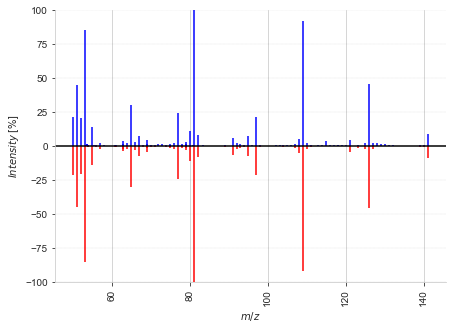

In [158]:
# head to tail plots
# of course you can also plot simple spctra plot with ms2plotter.ms2_plot()
ms2plotter.head_to_tail_plot(data.iloc[0]['msms'], data.iloc[0]['msms_denoised'], ifnormalized=False)

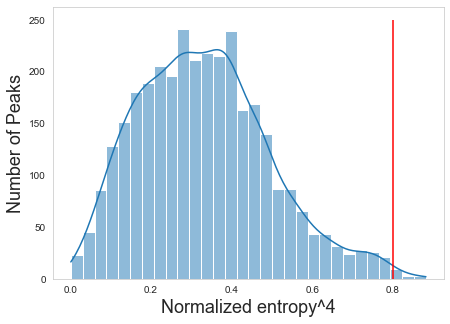

In [124]:
# plotting distribution of normalized entropy, not necessary
# fig, ax = plt.subplots(
#     figsize = (7, 5)
#                       )
# ax= sns.histplot(data=data, x="normalized_entroy_denoised", multiple="stack", kde = True,
#                  # hue="evaluations"
#                  )
# # ax.yaxis
# plt.vlines(x =0.8, ymin = 0, ymax=250,colors='red')
# # ax = sns.histplot(data=data_ead_r, x="diff_recalibrated", multiple="stack", kde = True,color = "green")
# # ax.set_title("Peak number difference after denoising", fontsize = 16)
# ax.set_xlabel("Normalized entropy^4", fontsize = 18)
# ax.set_ylabel("Number of Peaks", fontsize = 18)
# ax.grid(False)
# # plt.legend(labels=["Before recalibration","After recalibration"], loc = 'upper right')
# plt.savefig('data/normalized_entropy.tiff', dpi = 300,facecolor = 'white', edgecolor = 'white')

# final verdict:
# there are also other useful tools upon request: include but not limit to: entropy similarity calculation, fast search/open search against public libraries, etc
